<i>Based mainly on the notebook of [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015 ([GitHub](https://github.com/jakevdp/sklearn_pycon2015/)), in addition to "Machine Learning" (chapter 3) by Tom Mitchell, "INTRODUCTORY APPLIED MACHINE LEARNING" lectures by Victor Lavrenko ([VL](http://www.inf.ed.ac.uk/teaching/courses/iaml/)), and [Machine Learning](https://class.coursera.org/ml-003/lecture)  by Andrew Ng.</i>



# Supervised Learning In-Depth: Random Forests

# Decision Trees 






Random forests are an example of a *ensemble learner* built on decision trees.
For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.

** Data : **
Lets consider a simple example. The question we want to answer is will Mr. X play tennis based on a random's day weather conditions. The data set might look something like this:
![tennis1](../images/tennis1.jpg)


**Set up a simple classical decision tree:**
We can split our data following different attributes to make a decision tree: 
![tennis2](../images/tennis2.jpg)


**ID3 Algorithm**

1- Choose the best attribute A to split the node (starting at root)

2- For each value of A, create a new child node

3- Split for child nodes 
   --> if pure: STOP
   --> else: SPLIT

** Atribute selection **

The binary splitting (yes/No) makes this extremely efficient.
As always, though, the trick is to *ask the right questions*.
This is where the algorithmic process comes in: in training a decision tree classifier, the algorithm looks at the features and decides which questions (or "splits") contain the most information.

Selecting the right A to split the data is crucial. Algorithms will usually calculate the "Gain" in entropy of a split following A to evaluate its importance. The gain is the entropy of a parent node minus some averaging over the entropies of the child nodes after splitting over A.

Entropy H(S)=-P(+)log_2(P(+)) - P(-)log_2(P(-)) where S is the subset of the training example and P+/P- is the % of + or - examples in S.


**Overfitting**

Decision trees can continue to split until each node is in a pure state, at worse containing just 1 example. They can **always** perfectly fit the training data, thus reducing the accuracy on test examples. Decision trees can have a tendancy to overfit. 

Two possible solutions:

1- Stop spliting when the number of examples in a node is not statistically significant.

2- Grow the tree fully then post-pune unecessary nodes.

![overfit](../images/overfit.png)

**Few notes on DTs **

1- Decision trees can handle missing data.

2- Good decision trees implementations are immune to noise (irrelevant attributes), because it will have a low entropy gain value.

3- Can split data only parallel to axis (no diagonal splitting)

### Creating a Decision Tree

Here's an example of a decision tree classifier in scikit-learn. We'll start by defining some two-dimensional labeled data:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

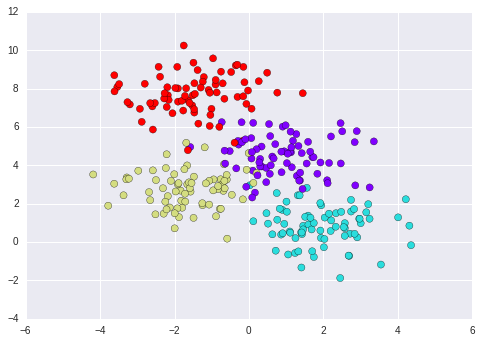

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

We have some convenience functions in the repository that help 

In [3]:
from fig_code import visualize_tree, plot_tree_interactive

Now using IPython's ``interact`` (available in IPython 2.0+, and requires a live kernel) we can view the decision tree splits:

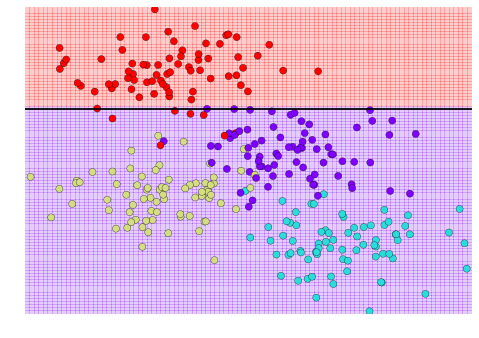

In [4]:
plot_tree_interactive(X, y);

Notice that at each increase in depth, every node is split in two **except** those nodes which contain only a single class.
The result is a very fast **non-parametric** classification, and can be extremely useful in practice.

**Question: Do you see any problems with this?**

### Decision Trees and over-fitting

One issue with decision trees is that it is very easy to create trees which **over-fit** the data. That is, they are flexible enough that they can learn the structure of the noise in the data rather than the signal! For example, take a look at two trees built on two subsets of this dataset:

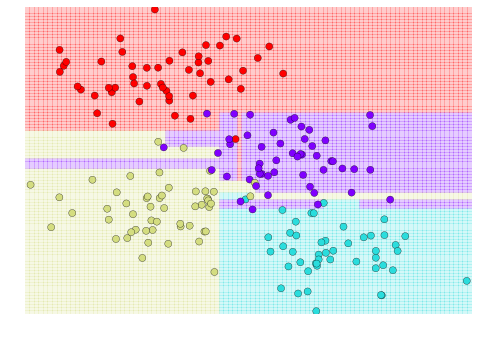

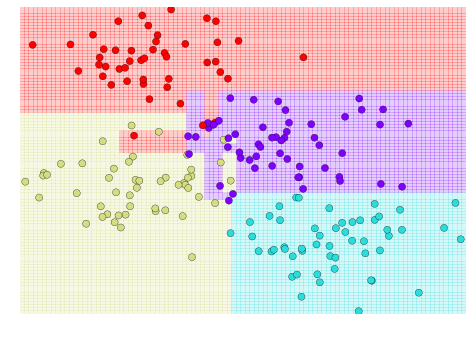

In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False)
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

The details of the classifications are completely different! That is an indication of **over-fitting**: when you predict the value for a new point, the result is more reflective of the noise in the model rather than the signal.

# Random Forests

One possible way to address over-fitting is to use an **Ensemble Method**: this is a meta-estimator which essentially averages the results of many individual estimators which over-fit the data. Somewhat surprisingly, the resulting estimates are much more robust and accurate than the individual estimates which make them up!

One of the most common ensemble methods is the **Random Forest**, in which the ensemble is made up of many decision trees which are in some way perturbed.

The basic idea behind a RF is simple :

1- Grow a number "K" of different Decision trees, randomised over both the subset of training examples and the subset of attributes. The DTs should be splitted all the way to the pure state with no punning.

2- Use all of them to make predictions on the test set, and follow the majority vote.

There are volumes of theory and precedent about how to randomize these trees, but as an example, let's imagine an ensemble of estimators fit on subsets of the data. We can get an idea of what these might look like as follows:

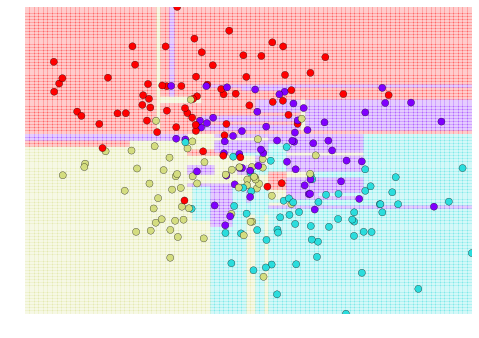

In [6]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
from IPython.html.widgets import interact
interact(fit_randomized_tree, random_state=[0, 100]);

See how the details of the model change as a function of the sample, while the larger characteristics remain the same!
The random forest classifier will do something similar to this, but use a combined version of all these trees to arrive at a final answer:

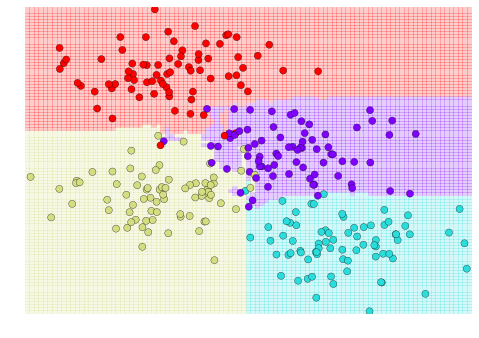

In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_tree(clf, X, y, boundaries=False);

By averaging over 100 randomly perturbed models, we end up with an overall model which is a much better fit to our data!

*(Note: above we randomized the model through sub-sampling... Random Forests use more sophisticated means of randomization, which you can read about in, e.g. the [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)

As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us even specifying a multi-period model!

## Example: Random Forest for Classifying Digits

We previously saw the **hand-written digits** data. Let's use that here to test the efficacy of the SVM and Random Forest classifiers.

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

In [9]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


To remind us what we're looking at, we'll visualize the first few data points:

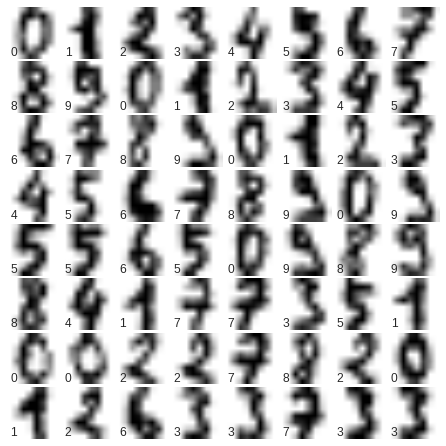

In [10]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary)
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a decision tree as follows:

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

# Random Forest
RF1=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=1, 
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                              max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, 
                              verbose=0, warm_start=False, class_weight=None)
RF1.fit(Xtrain, ytrain)
ypred1 = RF1.predict(Xtest)



# Decision Tree
DT1 = DecisionTreeClassifier(max_depth=None)
DT1.fit(Xtrain, ytrain)
ypred2 = DT1.predict(Xtest)



We can check the accuracy of these classifiers:

In [12]:
metrics.accuracy_score(ypred1, ytest)

0.97333333333333338

In [13]:
metrics.accuracy_score(ypred2, ytest)

0.83777777777777773

**Accuracy of the Random Forest as a function of the number of Decision Trees:**

![RF-nE](../images/rf2.jpg)

### Exercise
1. Repeat this classification task with ``sklearn.ensemble.RandomForestClassifier``.  How does the ``max_depth``, ``max_features``, and ``n_estimators`` affect the results?
2. Try this classification with ``sklearn.svm.SVC``, adjusting ``kernel``, ``C``, and ``gamma``. Which classifier performs optimally?
3. Try a few sets of parameters for each model and check the F1 score (``sklearn.metrics.f1_score``) on your results. What's the best F1 score you can reach?

**RandomForestClassifier parameters: **

class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)


The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. 

The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=n_features for regression problems, and max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in the data).

Good results are often achieved when setting max_depth=None in combination with min_samples_split=1 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of ram. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization error can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.


**n_estimators** : integer, optional (default=10)
The number of trees in the forest.

**criterion** : string, optional (default=”gini”)
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.

**max_features** : int, float, string or None, optional (default=”auto”)

The number of features to consider when looking for the best split:

If int, then consider max_features features at each split.

If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.

If “auto”, then max_features=sqrt(n_features).

If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

If “log2”, then max_features=log2(n_features).

If None, then max_features=n_features.

Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features. Note: this parameter is tree-specific.

**max_depth** : integer or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Ignored if max_leaf_nodes is not None. Note: this parameter is tree-specific.

**min_samples_split** : integer, optional (default=2)
The minimum number of samples required to split an internal node. Note: this parameter is tree-specific.

**min_samples_leaf** : integer, optional (default=1)
The minimum number of samples in newly created leaves. A split is discarded if after the split, one of the leaves would contain less then min_samples_leaf samples. Note: this parameter is tree-specific.

**min_weight_fraction_leaf** : float, optional (default=0.)
The minimum weighted fraction of the input samples required to be at a leaf node. Note: this parameter is tree-specific.

**max_leaf_nodes** : int or None, optional (default=None)
Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes. If not None then max_depth will be ignored. Note: this parameter is tree-specific.

**bootstrap** : boolean, optional (default=True)
Whether bootstrap samples are used when building trees.

**oob_score** : bool
Whether to use out-of-bag samples to estimate the generalization error.

**n_jobs** : integer, optional (default=1)
The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.

**random_state** : int, RandomState instance or None, optional (default=None)
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

**verbose** : int, optional (default=0)
Controls the verbosity of the tree building process.

**warm_start** : bool, optional (default=False)
When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.

**class_weight** : dict, list of dicts, “balanced”, “balanced_subsample” or None, optional
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.
For multi-output, the weights of each column of y will be multiplied.
Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

# Logistic regression: The simplest classifier

Lets take the basic example of a tumor that can classified as malignant or not as a function of its size.
The simplest way to fit the training examples is with a linear hypothesis (called in this case a Logistic regression) that is equal to 1 if the tumor is malignant and 1 if it is benign.

![lre](../images/lre.png)

Or, more adequately, the hypothesis will have the following (Sigmoid function) form:

![hypothesis](../images/hypothesis.jpg)

The logistic regression Hypothesis is interpreted as the probability that y is equal to 1 for input z.

The Cost function for logistic regression is defined as:

Cost(z,y) = -y log(z) - (1-y)log(1-z)

For y=1 --> 1-y=0 , Hypothesis=1 and Cost = 0

For y=0 --> ylog(z)=0, Hypothesis=0 and Cost tends to + infinity

Or, Graphically:

![tennis1](../images/cost.png)